In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/youtube-comments-spam-dataset/Youtube-Spam-Dataset.csv


# Import-Necessary-Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

# Load the Data

In [3]:
df = pd.read_csv("/kaggle/input/youtube-comments-spam-dataset/Youtube-Spam-Dataset.csv")

In [4]:
df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",PSY - GANGNAM STYLE(?????) M/V,1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,PSY - GANGNAM STYLE(?????) M/V,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,PSY - GANGNAM STYLE(?????) M/V,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,PSY - GANGNAM STYLE(?????) M/V,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,PSY - GANGNAM STYLE(?????) M/V,1


# Sanity Check of Data

In [5]:
df.shape

(1956, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   VIDEO_NAME  1956 non-null   object
 5   CLASS       1956 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 91.8+ KB


In [7]:
df.isnull().sum()

COMMENT_ID      0
AUTHOR          0
DATE          245
CONTENT         0
VIDEO_NAME      0
CLASS           0
dtype: int64

In [8]:
df.duplicated().sum()

3

In [9]:
df['CLASS'].value_counts()

CLASS
1    1005
0     951
Name: count, dtype: int64

# Exploratory Data Anlaysis (EDA)

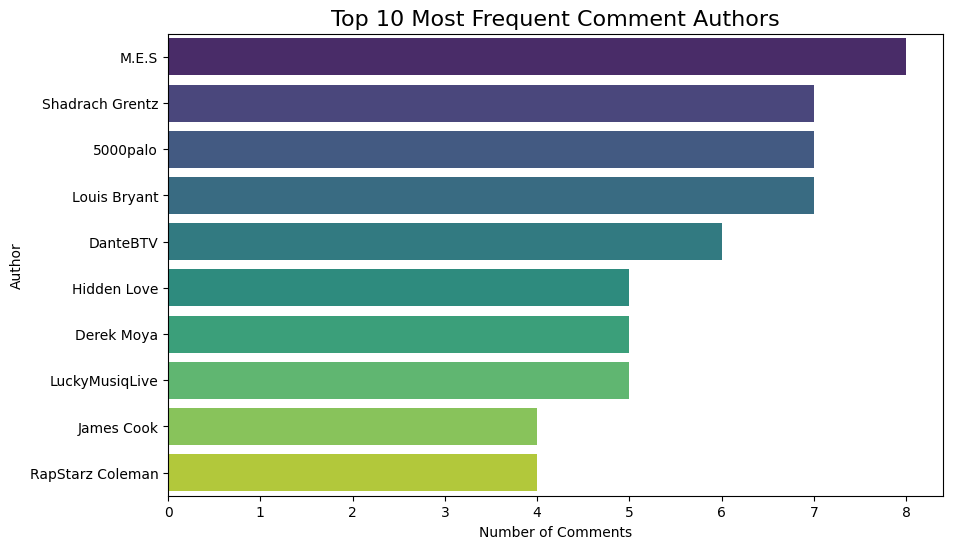

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df['AUTHOR'].value_counts().head(10).values, 
            y=df['AUTHOR'].value_counts().head(10).index, palette='viridis')
plt.title('Top 10 Most Frequent Comment Authors', fontsize=16)
plt.xlabel('Number of Comments')
plt.ylabel('Author')
plt.show()

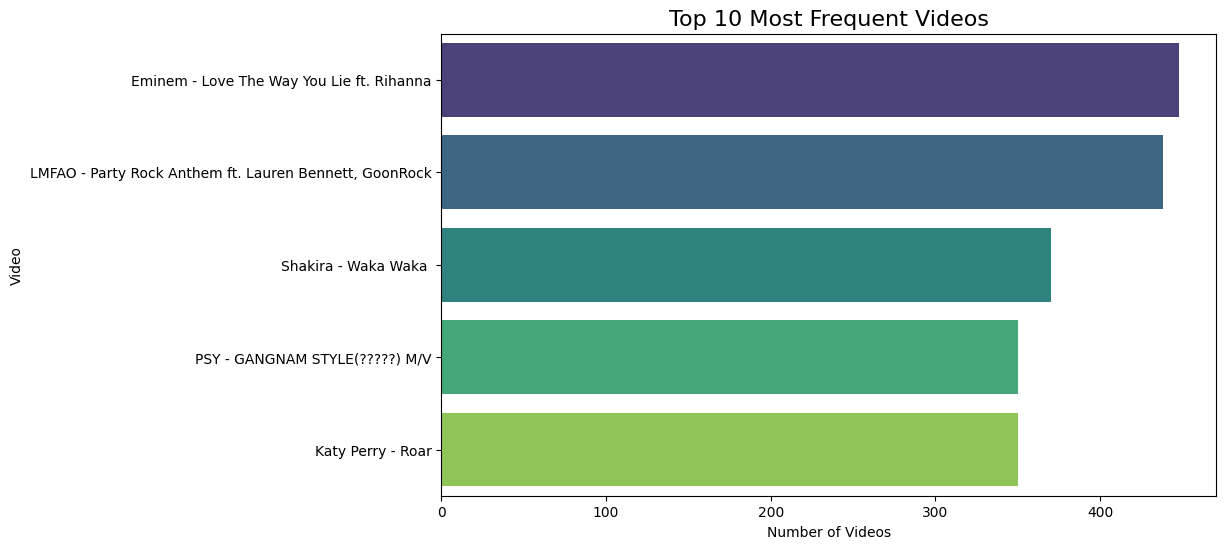

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df['VIDEO_NAME'].value_counts().head(5).values, 
            y=df['VIDEO_NAME'].value_counts().head(5).index, palette='viridis')
plt.title('Top 10 Most Frequent Videos', fontsize=16)
plt.xlabel('Number of Videos')
plt.ylabel('Video')
plt.show()

## What days were the most comments written?

In [12]:
df["DATE"] = df["DATE"].apply(lambda x: str(x).split('T')[0])

In [13]:
df["DATE"].value_counts().sort_values(ascending=False)[1:5]

DATE
2014-11-07    74
2014-11-08    68
2015-05-26    66
2015-05-23    59
Name: count, dtype: int64

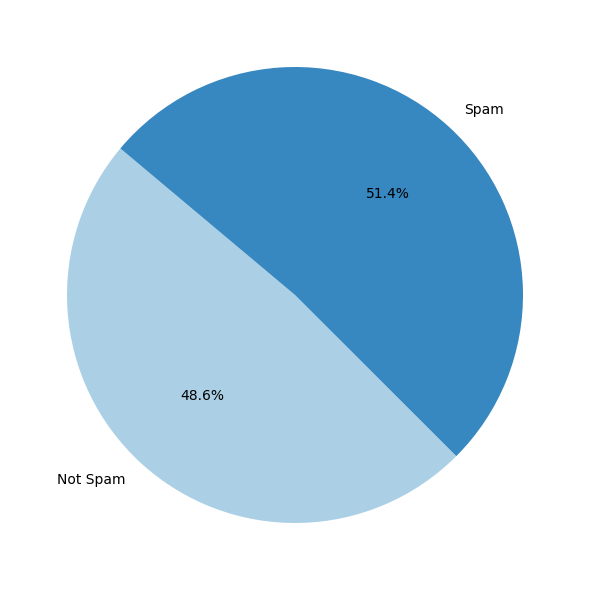

In [14]:
spam_counts = df['CLASS'].value_counts().sort_index()

palette = sns.color_palette("Blues", n_colors=len(spam_counts))
fig = plt.figure(figsize=(10, 6))
plt.pie(spam_counts, autopct='%1.1f%%', startangle=140, colors=palette, labels=["Not Spam", "Spam"])
plt.tight_layout()
plt.show()

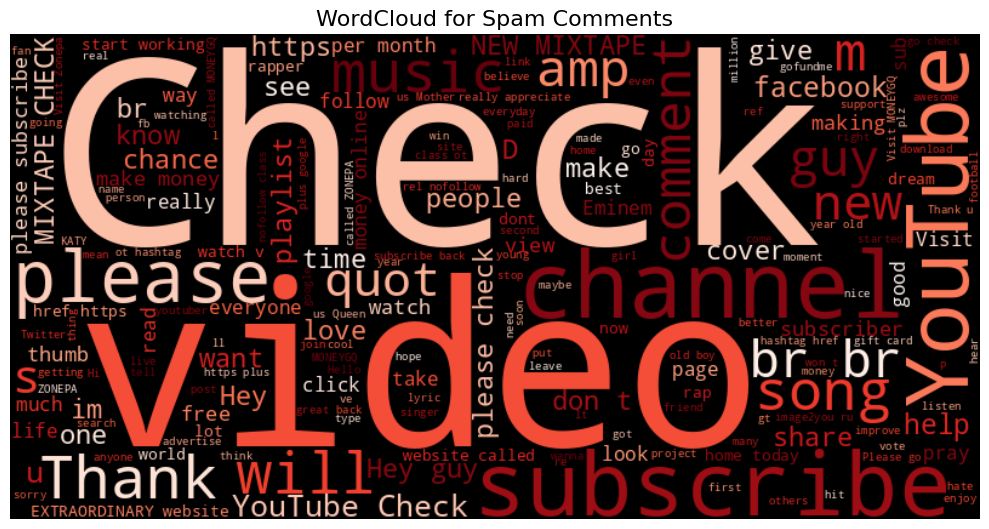

In [15]:
spam_comments = ' '.join(df[df['CLASS'] == 1]['CONTENT'])
spam_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(spam_comments)

plt.figure(figsize=(10, 6))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Spam Comments', fontsize=16)
plt.tight_layout()  # Adjust the layout
plt.show()

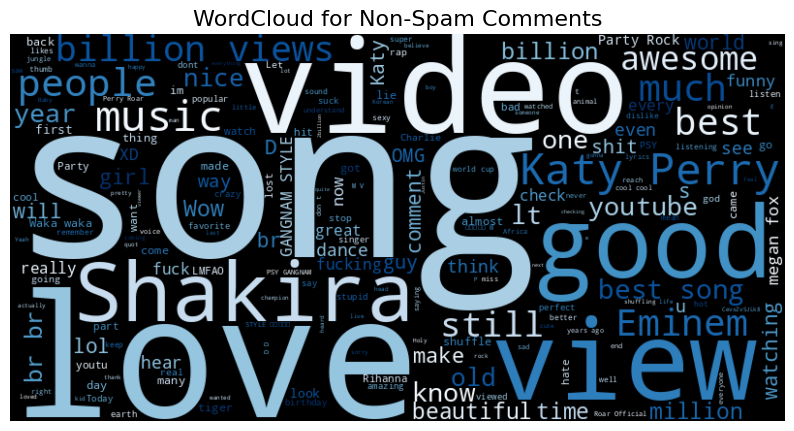

In [16]:
non_spam_comments = ' '.join(df[df['CLASS'] == 0]['CONTENT'])
non_spam_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Blues').generate(non_spam_comments)

plt.figure(figsize=(10, 6))
plt.imshow(non_spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Non-Spam Comments', fontsize=16)
plt.show()

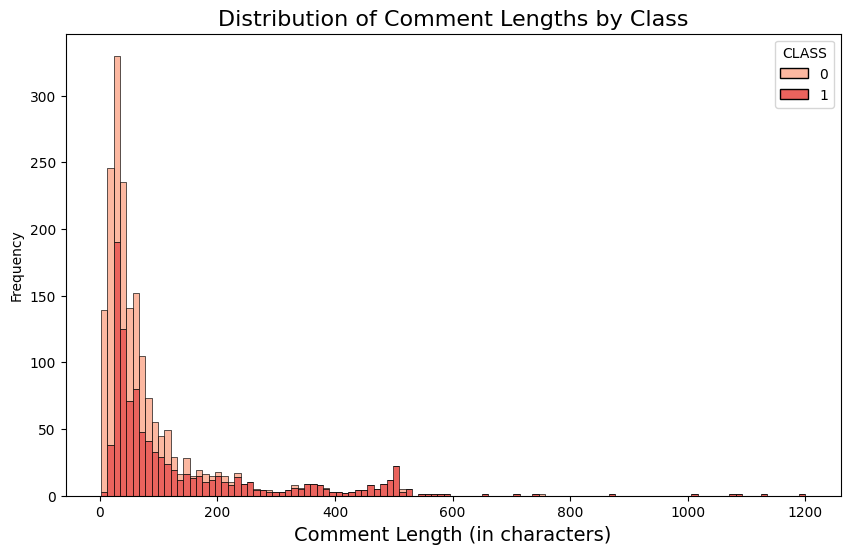

In [17]:
df['Comment Length'] = df['CONTENT'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df, x='Comment Length', hue='CLASS', multiple='stack', palette='Reds')
plt.title('Distribution of Comment Lengths by Class', fontsize=16)
plt.xlabel('Comment Length (in characters)', fontsize=14)
plt.ylabel('Frequency')
plt.show()

# Garbage Treatment

In [18]:
df.drop_duplicates(inplace=True)

# Feature Selection

In [19]:
df["comment_info"] = df["AUTHOR"] + "  " + df["VIDEO_NAME"] + "  " + df["CONTENT"]

In [20]:
X = df["comment_info"]
y = df["CLASS"]

# Encoding

In [21]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(X)

In [22]:
X.shape

(1953, 6980)

# Train Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1562, 6980), (391, 6980), (1562,), (391,))

# Model Building

In [24]:
clf = LinearSVC(random_state=42)

In [25]:
clf.fit(X_train, y_train)

LinearSVC(random_state=42)

# Evaluation

In [26]:
y_pred = clf.predict(X_test)

In [27]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       170
           1       0.99      0.94      0.96       221

    accuracy                           0.96       391
   macro avg       0.96      0.96      0.96       391
weighted avg       0.96      0.96      0.96       391



In [28]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[167   3]
 [ 13 208]]


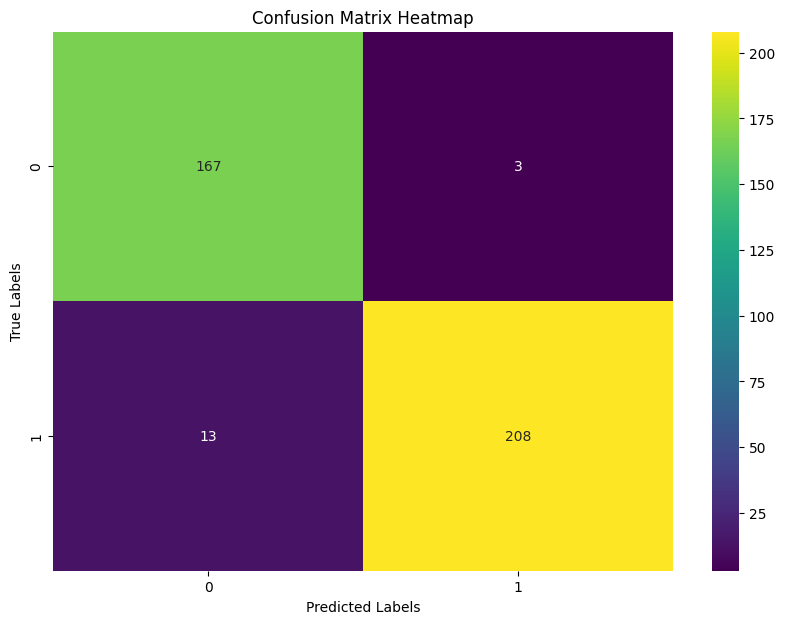

In [29]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()